In [ ]:
# instalação da biblioteca gdown
!pip install gdown

In [ ]:
# importando a biblioteca
import gdown
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!gdown --id 16Ja0zGricE41-B8rO5POXR38q6XxiVfO

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=16Ja0zGricE41-B8rO5POXR38q6XxiVfO
From (redirected): https://drive.google.com/uc?id=16Ja0zGricE41-B8rO5POXR38q6XxiVfO&confirm=t&uuid=1a5a6c39-8f48-4798-b65b-0beb7e8646a7
To: /content/utkface_cropped_face.zip
100% 177M/177M [00:05<00:00, 31.1MB/s]


In [ ]:
# biblioteca para descomprimir o arquivo zip
import zipfile
import os


In [ ]:
# funçao que realiza a descompressão do arquivo
def unzip_dataset(filename, directory):
  """
  filename: nome do arquivo, incluir o endereço onde está localizado o arquivo
  directory: pasta onde será decomprimido o arquivo
  """
  zip_ref = zipfile.ZipFile(filename, 'r')
  zip_ref.extractall(directory)
  zip_ref.close()

In [ ]:
utk_dir = unzip_dataset('/content/utkface_cropped_face.zip','/content/utk_face_cropped')

##Distribuicao dos dados da utk

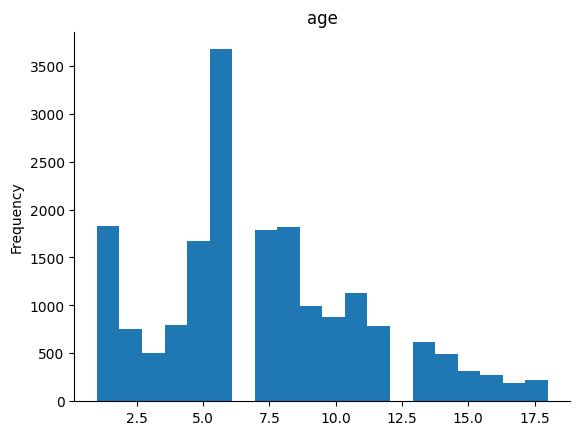

In [ ]:
# @title age

from matplotlib import pyplot as plt
data_utk = pd.read_csv("/content/utk_face_cropped/utkface_cropped_face/new_utkface_labels.csv")


data_utk['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data_utk = data_utk.astype({'age':'int32'})

In [ ]:
print(data_utk.head())

                                   image  age intervalo
0  49_1_0_20170104185652921.jpg.chip.jpg   10     45-50
1  17_1_0_20170109214200825.jpg.chip.jpg    4     15-20
2  17_1_4_20170103201233799.jpg.chip.jpg    4     15-20
3  29_0_4_20170103235921692.jpg.chip.jpg    6     25-30
4  41_0_2_20170116192329504.jpg.chip.jpg    9     40-45


In [ ]:
import os

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset,DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from datetime import datetime
from PIL import Image

In [ ]:
class CSVDataset(Dataset):
    def __init__(self, csv_file, dir = "", transform = None,):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.dir = dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].to_numpy()
        new_path = os.path.join(self.dir, row[0])

        #image = cv2.imread(new_path)
        image = Image.open(new_path)

        nimage = self.transform(image)

        label = torch.tensor(row[1], dtype=torch.long)

        return nimage, label

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


In [ ]:
data_train_utk = CSVDataset('/content/utk_face_cropped/utkface_cropped_face/new_utkface_labels.csv', dir="/content/utk_face_cropped/utkface_cropped_face/final_files", transform=train_transform)

In [ ]:
train_size = int(0.8 * len(data_train_utk))

In [ ]:
val_size = len(data_train_utk) - train_size

In [ ]:
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split

In [ ]:
train_dataset, val_dataset = random_split(data_train_utk, [train_size, val_size])

In [ ]:
batch_size  = 128
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size=batch_size,
    shuffle= True
)

In [ ]:
val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size=batch_size,
    shuffle= True
)

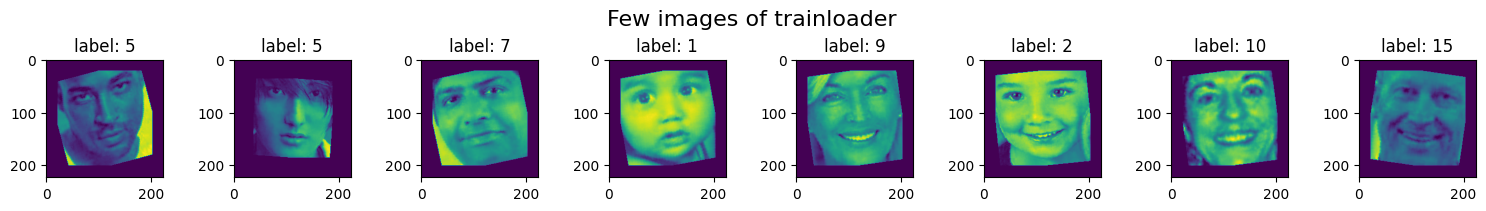

In [ ]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 8
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of trainloader", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:])
    ax[i].set_title(f"label: {y[i].numpy()}")
  break


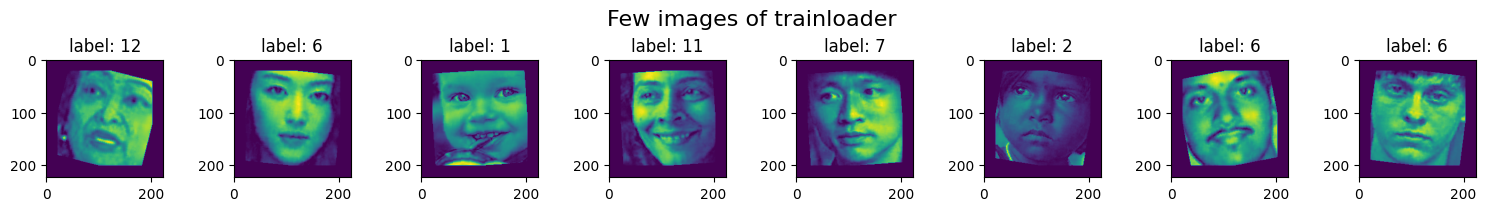

In [ ]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 8
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of trainloader", fontsize=16)
for x, y in val_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:])
    ax[i].set_title(f"label: {y[i].numpy()}")
  break


In [ ]:
for x, y in train_loader:
    print("Valores únicos nos rótulos:", y.unique())
    print("Forma dos rótulos:", y.shape)
    assert y.max() < 19

Valores únicos nos rótulos: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18])
Forma dos rótulos: torch.Size([128])
Valores únicos nos rótulos: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18])
Forma dos rótulos: torch.Size([128])
Valores únicos nos rótulos: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
Forma dos rótulos: torch.Size([128])
Valores únicos nos rótulos: tensor([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
Forma dos rótulos: torch.Size([128])
Valores únicos nos rótulos: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
Forma dos rótulos: torch.Size([128])
Valores únicos nos rótulos: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18])
Forma dos rótulos: torch.Size([128])
Valores únicos nos rótulos: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
Forma dos rótulos: torch.Size([128])
Va

## Resnet alterando a ultima camada para 19 saidas
Otimizador SGD

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features  # Número de entradas da camada totalmente conectada original
model.fc = torch.nn.Linear(num_ftrs, 19)  # Substituir pela nova camada com 101 saídas

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
model.to(DEVICE)

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    '''
    model: modelo (a rede neural)
    criterion: função de perda (loss)
    optimizer: otimizador
    train_loader: dataloader do conjunto de treino
    test_loader: dataloader do conjunto de teste
    epochs: número de épocas
    '''
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        # Treino
        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        #
        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} val Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

In [ ]:
def predict_module(model, test_loader):
    '''
    model: modelo (a rede neural)
    test_loader: dataloader do conjunto de teste
    '''
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

In [ ]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

In [ ]:
def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            # Acesse os dados corretamente
            if isinstance(batch, dict):
                images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            else:
                images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)

            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
from sklearn import metrics

##Experimento 1

Epoch 1/10 Train Loss: 2.3324 val Loss: 2.078530005613963 Duracao: 0:01:57.507517
Epoch 2/10 Train Loss: 1.9244 val Loss: 1.8550918062527975 Duracao: 0:01:56.943875
Epoch 3/10 Train Loss: 1.7647 val Loss: 1.7357564528783163 Duracao: 0:01:57.129873
Epoch 4/10 Train Loss: 1.6649 val Loss: 1.670635724067688 Duracao: 0:01:57.552410
Epoch 5/10 Train Loss: 1.5963 val Loss: 1.6595720450083415 Duracao: 0:01:57.146823
Epoch 6/10 Train Loss: 1.5368 val Loss: 1.6493161559104919 Duracao: 0:01:56.991054
Epoch 7/10 Train Loss: 1.4889 val Loss: 1.6205990711847942 Duracao: 0:01:57.178237
Epoch 8/10 Train Loss: 1.4484 val Loss: 1.6100903391838073 Duracao: 0:01:57.210449
Epoch 9/10 Train Loss: 1.4009 val Loss: 1.6365150888760884 Duracao: 0:01:57.124908
Epoch 10/10 Train Loss: 1.3712 val Loss: 1.6114711085955302 Duracao: 0:01:56.979834


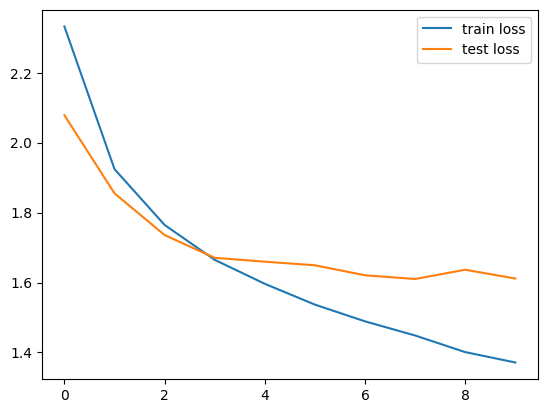

In [ ]:
train_losses, val_losses = fit(model, criterion, optimizer, train_loader, val_loader, 10) # Na nona epoca ja deu overfitting
plot_losses(train_losses,val_losses)
predicted,true_labels = predict_module(model,val_loader)

In [ ]:
cm = metrics.confusion_matrix(true_labels,predicted)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9','Classe 10','Classe 11','Classe 12','Classe 13','Classe 14','Classe 15','Classe 16','Classe 17','Classe 18'])

In [ ]:
test(model,val_loader)

(0.012955683952794735, 0.3888740304894357)

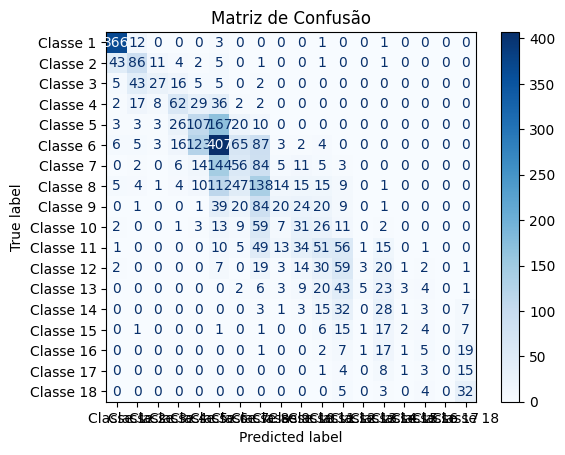

In [ ]:
disp.plot(values_format='.2f', xticks_rotation='vertical')

# Adicionar título
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
torch.save(model,"/content/modelfinal.pht")

In [ ]:
!gdown --id 1K8zvQT79-RaiNuxZbBGF0gOMyGXKIYh_

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1K8zvQT79-RaiNuxZbBGF0gOMyGXKIYh_
To: /content/FGNET_cropped.zip
100% 17.6M/17.6M [00:00<00:00, 31.4MB/s]


In [ ]:
fg_dir = unzip_dataset('/content/FGNET_cropped.zip','/content/fg_net_cropped')

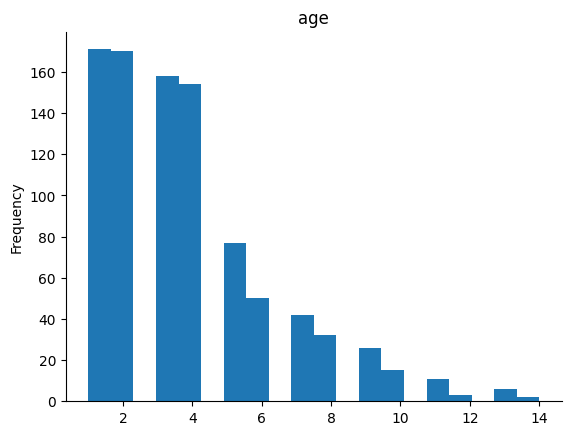

In [ ]:
df_fg = pd.read_csv("/content/fg_net_cropped/FGNET_cropped/new_fgnet_labels.csv")


df_fg['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
test_data_set = CSVDataset('/content/fg_net_cropped/FGNET_cropped/new_fgnet_labels.csv', dir="/content/fg_net_cropped/FGNET_cropped/final_files", transform=test_transform)

In [ ]:
batch_size = 128
test_loader = torch.utils.data.DataLoader(
    dataset = test_data_set,
    batch_size=batch_size,
    shuffle= True
)

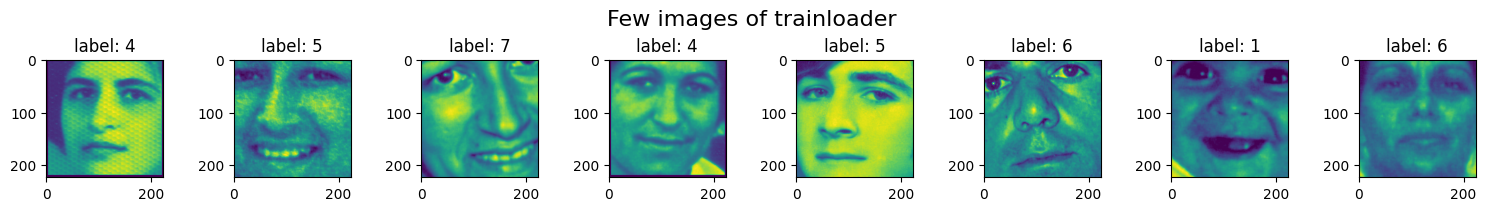

In [ ]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 8
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of trainloader", fontsize=16)
for x, y in test_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:])
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

In [ ]:
predicted_test,true_labels_test = predict_module(model,test_loader)
cm_test = metrics.confusion_matrix(true_labels_test,predicted_test)
disp_test = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9','Classe 10','Classe 11','Classe 12','Classe 13','Classe 14','Classe 15','Classe 16','Classe 17','Classe 18'])

In [ ]:
test(model,test_loader)

(0.01924858098461688, 0.3031624863685932)

ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of labels (18).

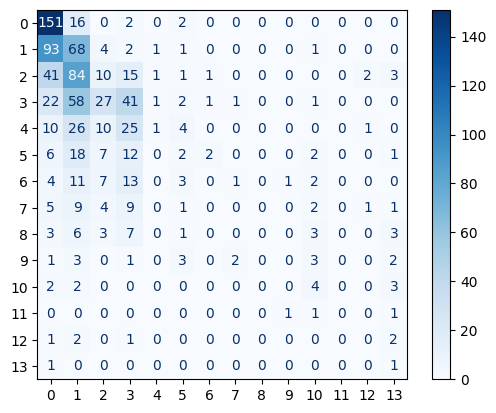

In [ ]:

disp_test.plot(values_format='.2f', xticks_rotation='vertical')
# Adicionar título
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
def calc_mae(model, data_loader, num_classes, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_labels = []
    all_predictions = []
    total_absolute_error = 0.0
    total_samples = 0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move os dados para a GPU
            outputs = model(inputs)  # Passa os dados pelo modelo

            # Obtém as previsões e calcula o MAE
            _, predicted = torch.max(outputs, 1)
            absolute_error = torch.abs(predicted.float() - labels.float())
            total_absolute_error += absolute_error.sum().item()
            total_samples += labels.size(0)

            # Armazena os rótulos e previsões
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())



    # Calcula o erro médio absoluto (MAE)
    mae = total_absolute_error / total_samples



    return  mae


In [ ]:
mae_val = calc_mae(model, val_loader, 19,DEVICE)
mae_test = calc_mae(model, test_loader, 19,DEVICE)
print(f"MAE Validação: {mae_val:.4f}")
print(f"MAE Teste: {mae_test:.4f}")

MAE Validação: 1.1254
MAE Teste: 1.7514


##Experimento 2

In [ ]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model.parameters(),
                                    lr=0.001,

                                    weight_decay=1e-3)

Epoch 1/10 Train Loss: 1.9685 val Loss: 2.6818181753158568 Duracao: 0:01:57.787361
Epoch 2/10 Train Loss: 1.7954 val Loss: 1.8773918350537617 Duracao: 0:01:57.911448
Epoch 3/10 Train Loss: 1.7833 val Loss: 1.8907174984614055 Duracao: 0:01:57.685246
Epoch 4/10 Train Loss: 1.7540 val Loss: 3.0128047307332357 Duracao: 0:01:58.351376
Epoch 5/10 Train Loss: 1.7328 val Loss: 1.8686302264531454 Duracao: 0:01:57.441544
Epoch 6/10 Train Loss: 1.7247 val Loss: 1.8321859916051229 Duracao: 0:01:57.383112
Epoch 7/10 Train Loss: 1.7111 val Loss: 1.867898992697398 Duracao: 0:01:57.442198
Epoch 8/10 Train Loss: 1.7088 val Loss: 1.935356318950653 Duracao: 0:01:57.393646
Epoch 9/10 Train Loss: 1.6873 val Loss: 1.7807382702827455 Duracao: 0:01:57.168098
Epoch 10/10 Train Loss: 1.6910 val Loss: 1.8065204660097758 Duracao: 0:01:57.435966


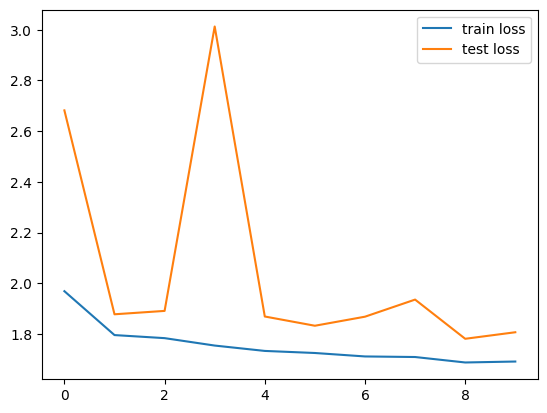

In [ ]:
train_losses2, val_losses2 = fit(model, criterion2, optimizer2, train_loader, val_loader, 10)
plot_losses(train_losses2,val_losses2)
predicted2,true_labels2 = predict_module(model,val_loader)
cm2 = metrics.confusion_matrix(true_labels2,predicted2)
disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9','Classe 10','Classe 11','Classe 12','Classe 13','Classe 14','Classe 15','Classe 16','Classe 17','Classe 18'])

In [ ]:
test(model,val_loader)

(0.014487908912489331, 0.3434073281626103)

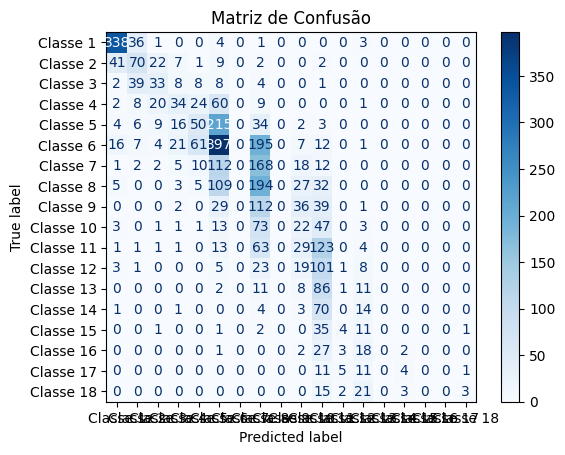

In [ ]:

disp2.plot(values_format='.2f', xticks_rotation='vertical')
# Adicionar título
plt.title('Matriz de Confusão')
plt.show()


In [ ]:
predicted_test2,true_labels_test2 = predict_module(model,test_loader)
cm_test2 = metrics.confusion_matrix(true_labels_test2,predicted_test2)
disp_test2 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test2,display_labels=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9','Classe 10','Classe 11','Classe 12','Classe 13','Classe 14','Classe 15','Classe 16','Classe 17','Classe 18'])


In [ ]:
test(model,test_loader)

(0.023912921206641742, 0.21919302071973829)

ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of labels (18).

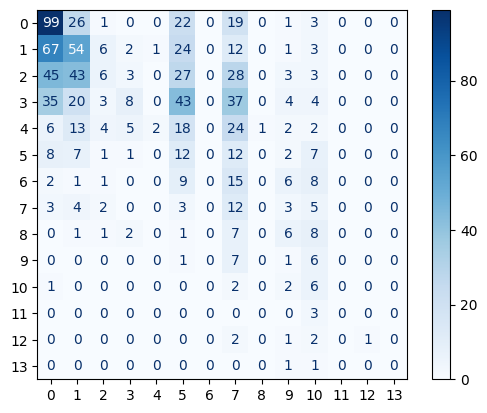

In [ ]:

disp_test2.plot(values_format='.2f', xticks_rotation='vertical')
# Adicionar título
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
mae_val2 = calc_mae(model, val_loader, 19,DEVICE)
mae_test2 = calc_mae(model, test_loader, 19,DEVICE)
print(f"MAE Validação: {mae_val2:.4f}")
print(f"MAE Teste: {mae_test2:.4f}")

MAE Validação: 1.3782
MAE Teste: 2.2486


tirar crop
adicionar mais camadas fc e colocar dropout .

##Experimento 3

In [ ]:
train_transform2 = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


In [ ]:
test_data_set2 = CSVDataset('/content/fg_net_cropped/FGNET_cropped/new_fgnet_labels.csv', dir="/content/fg_net_cropped/FGNET_cropped/final_files", transform=test_transform2)

In [ ]:
test_loader2 = torch.utils.data.DataLoader(
    dataset = test_data_set2,
    batch_size=batch_size,
    shuffle= True
)

In [ ]:
data_train_utk2 = CSVDataset('/content/utk_face_cropped/utkface_cropped_face/new_utkface_labels.csv', dir="/content/utk_face_cropped/utkface_cropped_face/final_files", transform=train_transform2)

In [ ]:
treino_utk_size = int(0.8 * len(data_train_utk2))

In [ ]:
teste_size_utk = len(data_train_utk2) - treino_utk_size

In [ ]:
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split

In [ ]:
# aqui esta a variavel de train com 80% e de teste com 20%
train_dataset_utk_2, test_dataset_utk_2 = random_split(data_train_utk2, [treino_utk_size, teste_size_utk])

In [ ]:
#aqui vamos pegar 10% do treino para validacao
train_size_utk3 = int(0.9 * len(train_dataset_utk_2))

In [ ]:
val_size_utk3 =  len(train_dataset_utk_2) - train_size_utk3

In [ ]:
train_dataset_utk_last, val_dataset_utk_last = random_split(train_dataset_utk_2, [train_size_utk3, val_size_utk3])

In [ ]:
batch_size  = 128
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset_utk_last,
    batch_size=batch_size,
    shuffle= True
)

In [ ]:
val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset_utk_last,
    batch_size=batch_size,
    shuffle= True
)

In [ ]:
test_utk_loader = torch.utils.data.DataLoader(
    dataset = test_dataset_utk_2,
    batch_size=batch_size,
    shuffle= True
)
# test loader ja carregado em cima test do fg_net

In [ ]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes=19):
        super(ModifiedResNet50, self).__init__()

        # Carregar a ResNet-50 pré-treinada
        self.resnet = models.resnet50(pretrained=True)

        # Remover a última camada fully connected
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove a camada final

        # Adicionar camadas fully connected
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten para transformar a saída 4D em 2D
            nn.Linear(2048, 512),  # 2048 é o número de características de saída da ResNet-50
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # Saída para a classe desejada
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc_layers(x)
        return x


In [ ]:
model_adaptado = ModifiedResNet50(num_classes=19)
print(model_adaptado)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


ModifiedResNet50(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_adaptado.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
model_adaptado.to(DEVICE)

Using device: cuda


ModifiedResNet50(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [ ]:
train_losses, val_losses = fit(model_adaptado, criterion, optimizer, train_loader, val_loader, 20) # Na nona epoca ja deu overfitting
plot_losses(train_losses,val_losses)
predicted,true_labels = predict_module(model_adaptado,test_loader)

Epoch 1/20 Train Loss: 1.7328 val Loss: 1.7473644117514293 Duracao: 0:01:48.024687
Epoch 2/20 Train Loss: 1.7021 val Loss: 1.7173056403795879 Duracao: 0:01:47.367596
Epoch 3/20 Train Loss: 1.6477 val Loss: 1.7136063675085704 Duracao: 0:01:47.298035
Epoch 4/20 Train Loss: 1.6130 val Loss: 1.686415433883667 Duracao: 0:01:47.014263
Epoch 5/20 Train Loss: 1.5727 val Loss: 1.6792496641476948 Duracao: 0:01:47.014833
Epoch 6/20 Train Loss: 1.5328 val Loss: 1.6725405752658844 Duracao: 0:01:47.516501
Epoch 7/20 Train Loss: 1.5117 val Loss: 1.6869561672210693 Duracao: 0:01:47.287980
Epoch 8/20 Train Loss: 1.4715 val Loss: 1.7004212935765584 Duracao: 0:01:47.192740


KeyboardInterrupt: 

In [ ]:
predicted,true_labels = predict_module(model_adaptado,val_loader)

In [ ]:
cm = metrics.confusion_matrix(true_labels,predicted)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Classe 1','Classe 2','Classe 3','Classe 4','Classe 5','Classe 6','Classe 7','Classe 8','Classe 9','Classe 10','Classe 11','Classe 12','Classe 13','Classe 14','Classe 15','Classe 16','Classe 17','Classe 18'])

In [ ]:
#teste val
test(model_adaptado,val_loader)

(0.013594564667997513, 0.3830213903743315)

In [ ]:
#teste utk
test(model_adaptado,test_utk_loader)

(0.013317751960978848, 0.3800481412142284)

In [ ]:
#teste fg-net
test(model_adaptado,test_loader)

(0.01543141867368276, 0.3718647764449291)

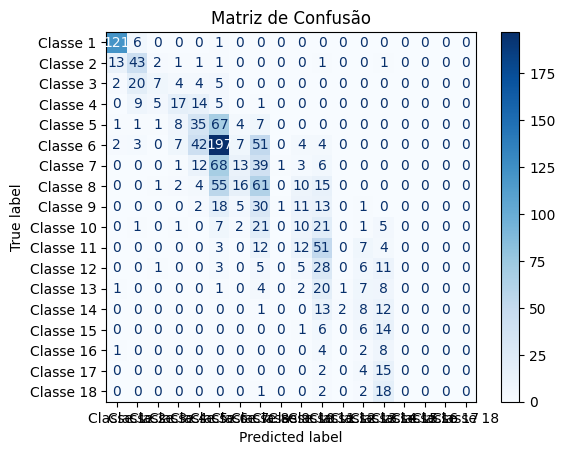

In [ ]:

disp.plot(values_format='.2f', xticks_rotation='vertical')
# Adicionar título
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
mae_val = calc_mae(model_adaptado, val_loader, 19,DEVICE)
mae_test = calc_mae(model_adaptado, test_utk_loader, 19,DEVICE)
mae_test_fg  = calc_mae(model_adaptado, test_loader, 19,DEVICE)
print(f"MAE Validação: {mae_val:.4f}")
print(f"MAE Teste utk : {mae_test:.4f}")
print(f"MAE Teste fg-net : {mae_test_fg:.4f}")


MAE Validação: 1.2166
MAE Teste utk : 1.1666
MAE Teste fg-net : 1.4427
